# Install Dependencies

```
pip install geopandas                  
pip install PySAL                       
pip install descartes 
```


# Download "Countries"

Download the first link under "Admin 0 – Countries" for "Download countries" from http://www.naturalearthdata.com/downloads/10m-cultural-vectors/

Unzip in your downloads directory. (Or any suitable location)


In [8]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import collections

shapefile = os.path.expanduser('~/Downloads/ne_10m_admin_0_countries.shp')

colors = 9
cmap = 'Blues'
figsize = (16, 10)

In [9]:
# Depends on: pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery

def run_query(query, project='mlab-sandbox'):
    #print query
    client = bigquery.Client(project=project)
    job = client.query(query)

    results = collections.defaultdict(list)
    for row in job.result(timeout=300):
        for key in row.keys():
            results[key].append(row.get(key))

    return pd.DataFrame(results)

In [10]:
gdf = gpd.read_file(shapefile)
gdf = gdf[['ISO_A2', 'CONTINENT', 'geometry']].to_crs('+proj=longlat')
gdf = gdf[gdf.CONTINENT == 'Africa']

gdf.sample(5)

,ISO_A2,CONTINENT,geometry
218,CV,Africa,(POLYGON ((-24.70433508999992 14.9008242860000...
21,-99,Africa,"POLYGON ((48.9391119999184 11.24912997616744, ..."
13,ET,Africa,"POLYGON ((34.07069786300013 9.454592111000068,..."
123,SZ,Africa,POLYGON ((31.94924320400008 -25.95810434999991...
162,MR,Africa,(POLYGON ((-8.68238521299989 27.28541575100012...


In [11]:
df = run_query("""
SELECT
  connection_spec.client_geolocation.country_name as country_name,
  connection_spec.client_geolocation.country_code as country_code,
  COUNT(*) as count
FROM
  `measurement-lab.ndt.base`
WHERE
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-01")
  AND connection_spec.client_geolocation.continent_code = "AF"
GROUP BY
  country_code, country_name
ORDER BY
 country_name, country_code, count desc
""")

In [12]:
df.sample(5)

,count,country_code,country_name
33,1491,NG,Nigeria
40,55,SO,Somalia
10,2,DJ,Djibouti
17,470,GN,Guinea
47,15,ZM,Zambia


In [13]:
merged = gdf.merge(df, left_on='ISO_A2', right_on='country_code')
merged.describe()

,count
count,46.000000
mean,1321.347826
std,5536.458468
min,2.000000
25%,9.000000
50%,24.500000
75%,255.500000
max,36748.000000


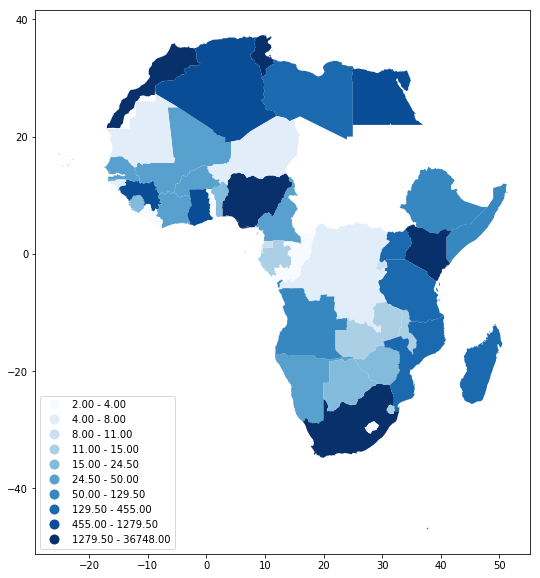

In [14]:
ax = merged.dropna().plot(column='count', cmap=cmap, figsize=figsize, scheme='Quantiles', k=10, legend=True, legend_kwds={"loc": 3})
